In [1]:
import os
thisDir = os.path.abspath(os.curdir)
os.chdir("../")

In [2]:
%matplotlib inline

In [3]:
import gpfanova, runFANOVA, gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [124]:
import matplotlib as mpl
import scipy
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram

def extractDelta(deltas):
    p = len(deltas.keys())
    n = deltas[deltas.keys()[0]].shape[1]
    
    a = np.zeros((p,n))
    prob = np.zeros((p,n))
    
    keys = deltas.keys()
    
    for i,k in enumerate(keys):
        samples = deltas[k]
        med = np.median(samples,0)
        samples = np.sort(samples,0)
        ns = samples.shape[0]
        lb,ub = .025*ns,.975*ns
        lb,ub = samples[[lb,ub],:]

        a[i,:] = med
        prob[i,:] = ub*lb>0 # any bounds without matching signs crosses the origin
        
        
    return keys,a,prob
    

def plot_delta(x,deltas,probability=False,cluster=False,plot_cluster=False,clusterShape=4,cluster_kwargs={},dendrogram_kwargs={},ytick_filter=lambda x: x):
    p = len(deltas.keys())
    n = x.shape[0]
    a = np.zeros((p,n))
    prob = np.zeros((p,n))
    yticks = [ytick_filter(k) for k in deltas.keys()]

    for i,k in enumerate(deltas.keys()):
        samples = deltas[k]
        med = np.median(samples,0)
        samples = np.sort(samples,0)
        ns = samples.shape[0]
        lb,ub = .025*ns,.975*ns
        lb,ub = samples[[lb,ub],:]

        a[i,:] = med
        prob[i,:] = ub*lb>0 # any bounds without matching signs crosses the origin

    if cluster:
        l = linkage(a,**cluster_kwargs)
        ind = leaves_list(l)
        a = a[ind,:]
        prob = prob[ind,:]
        yticks = [yticks[j] for j in ind]
        
        if plot_cluster:
            ax = plt.subplot2grid((1,clusterShape),(0,0),colspan=1,rowspan=1)
            dendrogram(l,no_labels=True,orientation='left',ax=ax,**dendrogram_kwargs)
            ax.set_xticks([])

    lim = np.max(np.abs(a))
    vmin = -lim
    vmax = lim

    if plot_cluster:
        ax = plt.subplot2grid((1,clusterShape),(0,1),colspan=clusterShape-1,rowspan=1)
    else:
        ax = plt.subplot2grid((1,5),(0,0),colspan=4,rowspan=1)
        
    if probability:
        # a[np.abs(prob-.5)<.475] = 0
        a[prob<1] = 0
        
    plt.imshow(a,cmap="RdBu_r",interpolation="none",vmin=vmin,vmax=vmax,origin='lower',aspect="auto")
    plt.yticks(range(p),yticks)
    i = np.arange(1.*n/4,n,1.*n/4)
    plt.xticks(i,[x[j].round(2) for j in i],fontsize=15)
    plt.xlabel("time (h)",fontsize=20)
    
    if plot_cluster:
#         if probability:
#             cbarAx,kwargs = mpl.colorbar.make_axes(ax)
#             cbar = mpl.colorbar.ColorbarBase(cbarAx,cmap='RdBu',ticks=[0,.5,1],**kwargs)
#             cbar.ax.set_yticklabels(['p(less\n than parent)\n>97.5%', 'no difference', 'p(greater\n than parent)\n>97.5%'],fontsize=15)
#         else:
        plt.colorbar()
    else:
        plt.colorbar()
        

In [4]:
x,y,effect,labels = runFANOVA.loadData(standard=True,paraquat=True,osmotic=True,peroxide=True,scaleX=False,otherEffects=['Experiment'])

In [5]:
effect

array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       ..., 
       [ 0,  2, 14],
       [ 0,  2, 14],
       [ 0,  2, 14]])

In [6]:
labels

Index([u'ura3', u'hlx1', u'asnC', u'trh2', u'trh3', u'trh4', u'copR', u'kaiC',
       u'idr1', u'idr2', u'troR', u'phoU', u'prp2', u'birA', u'trmB', u'arcR',
       u'VNG0039', u'VNG2268', u'VNG0471', u'VNG1029', u'VNG2614', u'rosR',
       u'hlx2', u'cspD1', u'cspD2', u'sirR', u'VNG0194H', u'hrg'],
      dtype='object')

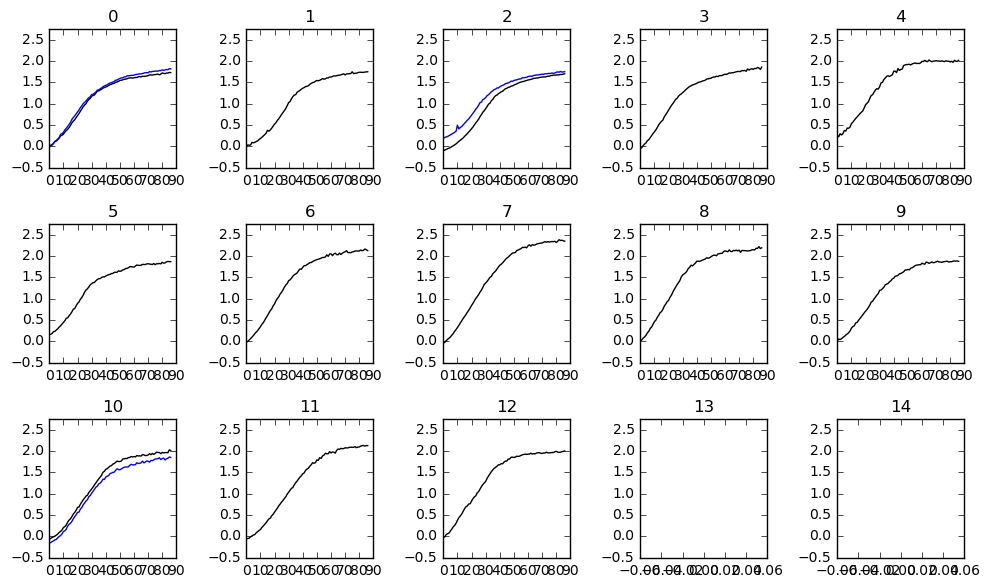

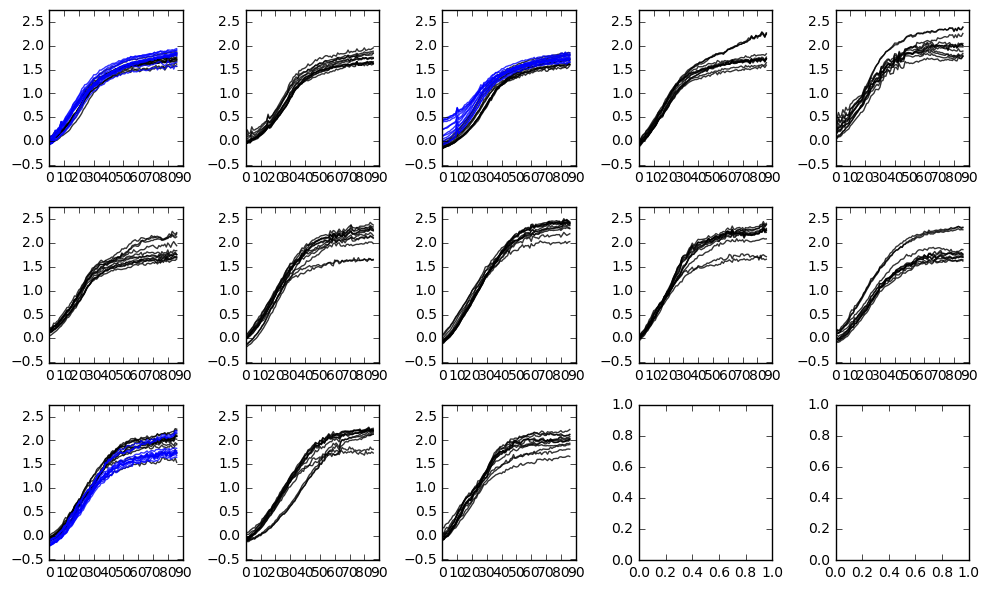

In [8]:
cmap = plt.get_cmap("spectral")
effs = np.unique(effect[:,2])
colors = [cmap(1.*p/len(effs)) for p in effs]
effects = ['standard','paraquat','osmotic','peroxide']

for e in range(len(effects)):
    for s in labels:
        if s == 'ura3':
            continue
            
#         mu = m.parameterSamples('mean').values + m.parameterSamples('beta_%d'%e).values
#         ura3 = m.parameterSamples('alpha_0').values + m.parameterSamples('(alpha,beta)_(0,%d)'%e).values

#         i = labels.tolist().index(s)
#         samples = m.parameterSamples('alpha_%d'%(i)).values + m.parameterSamples('(alpha,beta)_(%d,%d)'%(i,e)).values

#         plt.figure(figsize=(16,6))

#         plt.subplot(131)
#         select = (effect[:,0] == 0) & (effect[:,1] == e)
#         y1 = y[:,select]
#         plt.plot(y1,c='k',alpha=.2);

#         select = (effect[:,0] == labels.tolist().index(s)) & (effect[:,1] == e)
#         y2 = y[:,select]
#         plt.plot(y2,c='b',alpha=.8);
#         plt.ylim(min(y2.min(),y1.min()),max(y1.max(),y2.max()))

#         plt.subplot(132)
#         plt.plot(x,y1.mean(1),c='k')
#         gpfanova.plot.plotFunctionSamples(ura3+mu,x,intervalKwargs={'tol':1e-3},c='k')
#         plt.plot(x,y2.mean(1),c='b')
#         gpfanova.plot.plotFunctionSamples(samples+mu,x,intervalKwargs={'tol':1e-3},c='b')
#         plt.ylim(min(y2.min(),y1.min()),max(y1.max(),y2.max()))

#         plt.subplot(133)
#         plt.plot([x.min(),x.max()],[0,0],'k',lw=3)
#         plt.plot(x,y2.mean(1)-y1.mean(1))
#         gpfanova.plot.plotFunctionSamples(samples-ura3,x,intervalKwargs={'tol':1e-3})

#         plt.tight_layout()
#         plt.savefig("figures/%s/%s.pdf"%(effects[e],s))

        plt.figure(figsize=(10,6))

        for p in effs:
            #print p

            plt.subplot(3,5,effs.tolist().index(p)+1)
            plt.title(p)
            select = (effect[:,0] == 0) & (effect[:,1] == e) & (effect[:,2] == p)
            plt.plot(y[:,select].mean(1),c='k');
            plt.ylim(y.min(),y.max())

            select = (effect[:,0] == labels.tolist().index(s)) & (effect[:,1] == e) & (effect[:,2] == p)
            plt.plot(y[:,select].mean(1),c='b');
            plt.ylim(y.min(),y.max())

        plt.tight_layout()
        plt.savefig("figures/%s/%s-batchEffects-alt.pdf"%(effects[e],s))

        plt.figure(figsize=(10,6))

        for p in effs:
            #print p

            plt.subplot(3,5,effs.tolist().index(p)+1)

            try:
                select = (effect[:,0] == 0) & (effect[:,1] == e) & (effect[:,2] == p)
                plt.plot(y[:,select],c='k',alpha=.8);
                plt.ylim(y.min(),y.max())
            except:
                pass

            try:
                select = (effect[:,0] == labels.tolist().index(s)) & (effect[:,1] == e) & (effect[:,2] == p)
                plt.plot(y[:,select],c='b',alpha=.8);
                plt.ylim(y.min(),y.max())
            except:
                pass

        plt.tight_layout()
        plt.savefig("figures/%s/%s-batchEffects-alt-all.pdf"%(effects[e],s))
        
        gc.collect()
        
        break
    break

In [101]:
# x,y,effect,labels = runFANOVA.loadData(standard=True,paraquat=True,osmotic=True,peroxide=True,scaleX=False,otherEffects=['Experiment'],
#                                        strains=['ura3','trmB','rosR','hlx1'])
# m = gpfanova.fanova.FANOVA(x,y,effect,interactions=[(0,1)],parameterFile='results/posteriorSamples_batchEffects_standard-paraquat-osmotic-peroxide_(ura3,trmB,rosR,hlx1).csv')

x,y,effect,labels = runFANOVA.loadData(standard=True,paraquat=True,osmotic=True,peroxide=True,scaleX=False,otherEffects=['Experiment'])
m = gpfanova.fanova.FANOVA(x,y,effect,interactions=[(0,1)],helmertConvert=True,parameterFile='results/posteriorSamples_interactions_helmertConvert_batchEffects_standard-paraquat-osmotic-peroxide_v13-run26257224.csv')

ERROR:gpfanova.base:design matrix is of rank 125, but there are 126 functions!


In [103]:
labels

Index([u'ura3', u'hlx1', u'asnC', u'trh2', u'trh3', u'trh4', u'copR', u'kaiC',
       u'idr1', u'idr2', u'troR', u'phoU', u'prp2', u'birA', u'trmB', u'arcR',
       u'VNG0039', u'VNG2268', u'VNG0471', u'VNG1029', u'VNG2614', u'rosR',
       u'hlx2', u'cspD1', u'cspD2', u'sirR', u'VNG0194H', u'hrg'],
      dtype='object')

In [104]:
m.parameter_history.shape

(334, 25067)

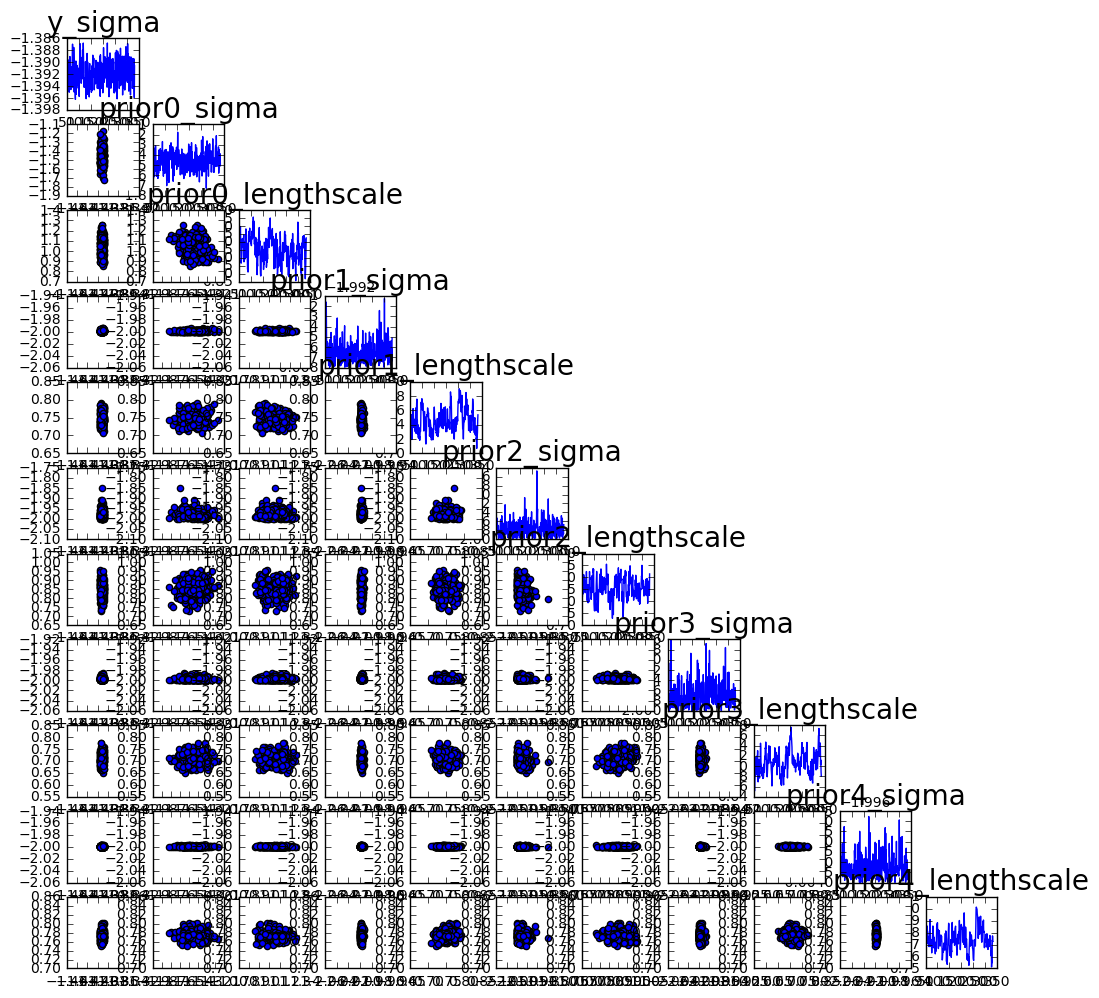

In [106]:
plt.figure(figsize=(12,12))
gpfanova.plot.plotHyperparameters(m,correlative=True,burnin=50)

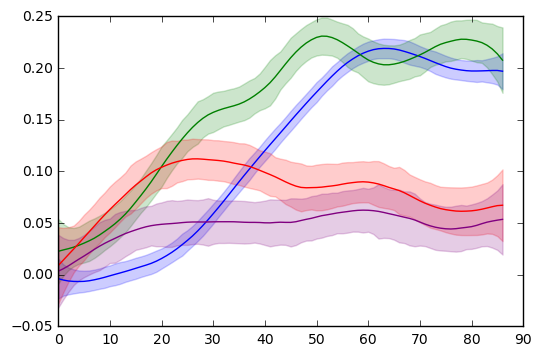

In [107]:
gpfanova.plot.plotFunctionSamples(m.parameterSamples('alpha_0').values)
gpfanova.plot.plotFunctionSamples(m.parameterSamples('alpha_1').values,c='g')
gpfanova.plot.plotFunctionSamples(m.parameterSamples('alpha_2').values,c='r')
gpfanova.plot.plotFunctionSamples(m.parameterSamples('alpha_3').values,c='purple')

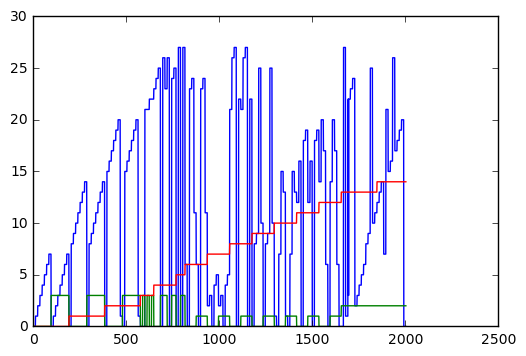

In [108]:
plt.plot(effect)

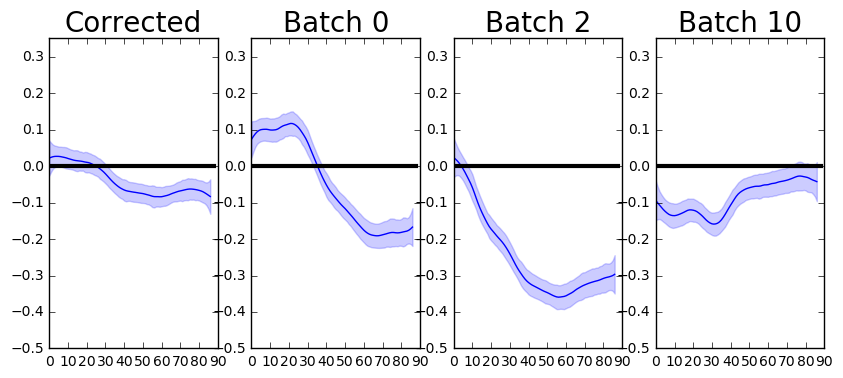

In [109]:
samples = m.parameterSamples('alpha_%d'%1).values
samples += m.parameterSamples('(alpha,beta)_(%d,0)'%1).values
samples -= m.parameterSamples('alpha_%d'%0).values
samples -= m.parameterSamples('(alpha,beta)_(%d,0)'%0).values

e = np.unique(effect[(effect[:,0]==1)&(effect[:,1]==0),2])

plt.figure(figsize=(10,4))

plt.subplot(1,e.shape[0]+1,1)
gpfanova.plot.plotFunctionSamples(samples,)
plt.plot([0,88],[0,0],c='k',lw=3)
plt.ylim(-.5,.35)
plt.title("Corrected",fontsize=20)

for i,z in enumerate(e):
    plt.subplot(1,e.shape[0]+1,i+2)
    
    samples += m.parameterSamples('gamma_%d'%z).values
    gpfanova.plot.plotFunctionSamples(samples,)
    samples -= m.parameterSamples('gamma_%d'%z).values
    
    #y1 = y[:,(effect[:,0]==1)&(effect[:,1]==0)&(effect[:,2]==z)].mean(1)
    #y2 = y[:,(effect[:,0]==0)&(effect[:,1]==0)&(effect[:,2]==z)].mean(1)
    #plt.plot(y1-y2)
    
    plt.plot([0,88],[0,0],c='k',lw=3)
    
    plt.ylim(-.5,.35)
    
    plt.title("Batch %d"%z,fontsize=20)

plt.savefig("figures/hlx1-standard-batchEffects.pdf",bbox_inches='tight')

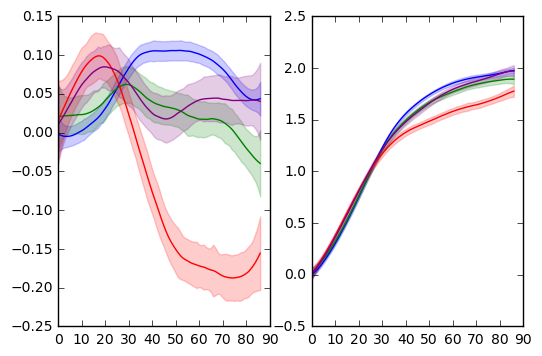

In [110]:
colors = ['b','g','r','purple']

for i in range(4):
    
    samples = m.parameterSamples('alpha_%d'%i).values
    samples += m.parameterSamples('(alpha,beta)_(%d,0)'%i).values
    
    plt.subplot(121)
    gpfanova.plot.plotFunctionSamples(samples,c=colors[i])
    
    samples += m.parameterSamples('beta_0').values
    samples += m.parameterSamples('mean').values
    plt.subplot(122)
    gpfanova.plot.plotFunctionSamples(samples,c=colors[i])

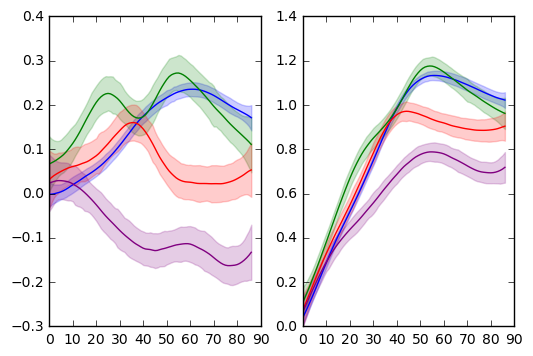

In [111]:
colors = ['b','g','r','purple']

for i in range(4):
    
    samples = m.parameterSamples('alpha_%d'%i).values
    samples += m.parameterSamples('(alpha,beta)_(%d,1)'%i).values
    
    plt.subplot(121)
    gpfanova.plot.plotFunctionSamples(samples,c=colors[i])
    
    samples += m.parameterSamples('beta_1').values
    samples += m.parameterSamples('mean').values
    plt.subplot(122)
    gpfanova.plot.plotFunctionSamples(samples,c=colors[i])

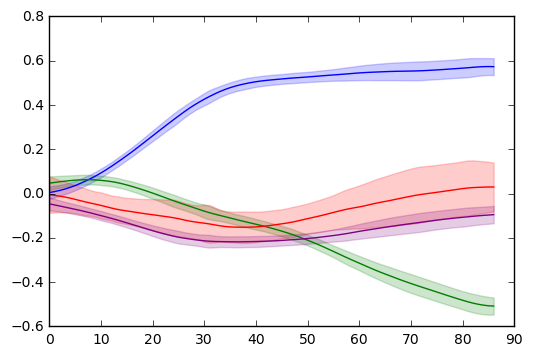

In [112]:
gpfanova.plot.plotFunctionSamples(m.parameterSamples('beta_0').values)
gpfanova.plot.plotFunctionSamples(m.parameterSamples('beta_1').values,c='g')
gpfanova.plot.plotFunctionSamples(m.parameterSamples('beta_2').values,c='r')
gpfanova.plot.plotFunctionSamples(m.parameterSamples('beta_3').values,c='purple')

In [69]:
select = effect[:,2] == j
effect[select,0]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

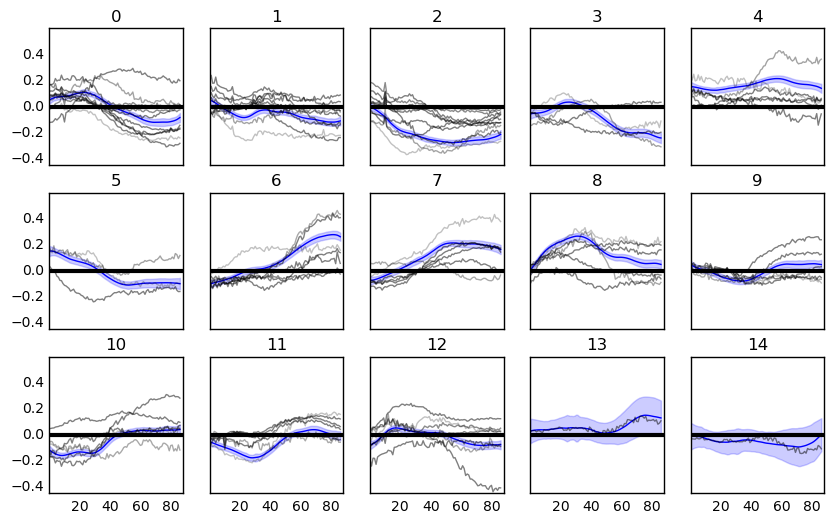

In [117]:
plt.figure(figsize=(10,6))
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     )

for j in range(m.mk[2]):
    ax = plt.subplot(3,5,j+1)
    gpfanova.plot.plotFunctionSamples(m.parameterSamples('gamma_%d'%j).values)
    plt.plot([0,88],[0,0],'k',lw=3)
    plt.title(j)
    plt.ylim(-.45,.6)
    if not j >= 10:
        plt.xticks([])
    else:
        plt.xticks(range(20,90,20))
        ax.xaxis.set_ticks_position('none')
    if not j%5==0:
        plt.yticks([])
    else:
        ax.yaxis.set_ticks_position('none')
    
    
    select = effect[:,2] == j
    
    for s in np.unique(effect[select,0]):
        select2 = (select)&(effect[:,0]==s)
        for e in np.unique(effect[select2,1]):
            select3 = (select2)&(effect[:,1]==e)
            select4 = (effect[:,0]==s)&(effect[:,1]==e)
            #plt.plot(y[:,select3].mean(1)-y[:,select4].mean(1),c='k',alpha=.5);
            #plt.plot((y[:,select3].T-y[:,(effect[:,0]==s)&(effect[:,1]==e)].mean(1)).T,c='k',alpha=.3);
            
            buff = 50
            plt.plot(y[:,select3].mean(1)-y[:,select4].mean(1),c='k',alpha=(1.*sum(select3)+buff)/(sum(select4)+2*buff));
            
#     select = (effect[:,0] == 0) & (effect[:,1] == 0) & (effect[:,2] == j)
#     select2 = (effect[:,0] == 0) & (effect[:,1] == 0)
#     plt.plot(y[:,select].mean(1)-y[:,select2].mean(1),c='k',alpha=.3);
    

plt.savefig("figures/batchEffects-all.pdf",bbox_inches='tight')

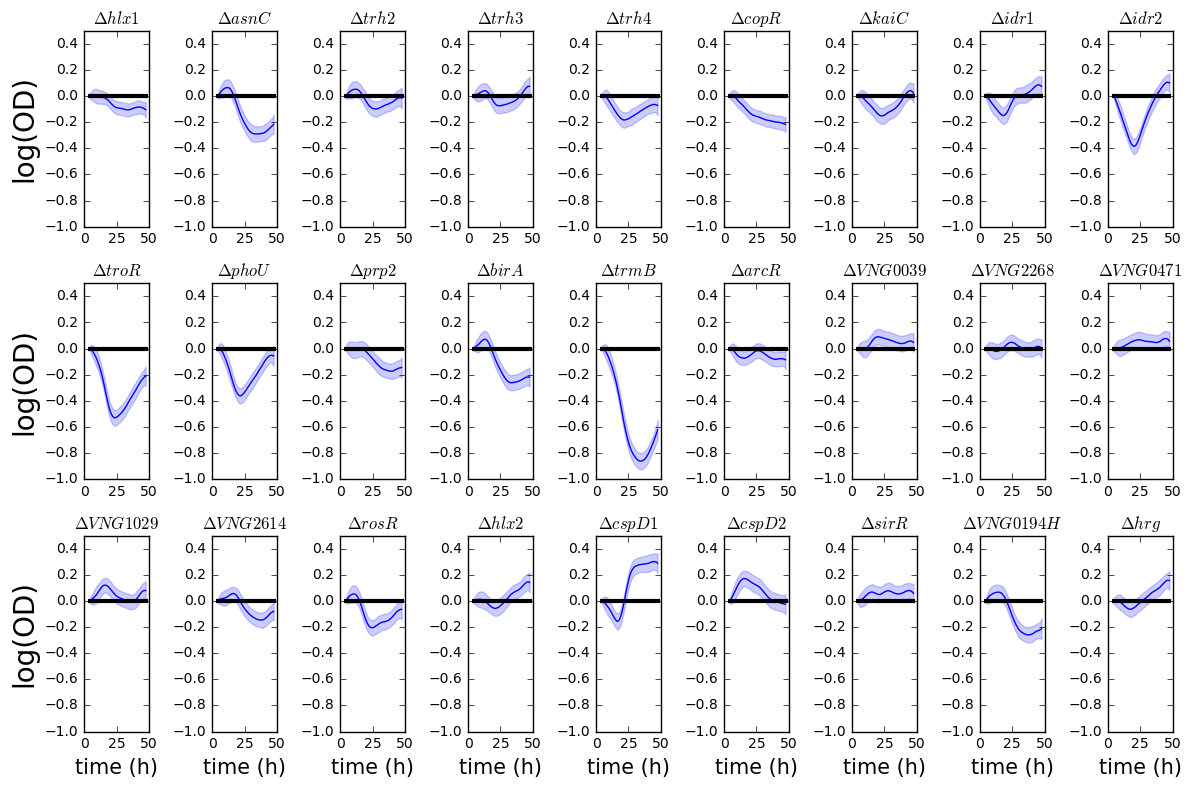

In [123]:
ura3 = m.parameterSamples('alpha_0').values + m.parameterSamples('(alpha,beta)_(0,0)').values

plt.figure(figsize=(12,8))
for i,s in enumerate(labels[1:]):
    
    plt.subplot(3,9,i+1)
    samples = m.parameterSamples('alpha_%d'%(i+1)).values + m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    samples = (samples.T-samples[:,0]).T
    gpfanova.plot.plotFunctionSamples(samples-ura3,m.x,intervalKwargs={'tol':1e-1})
    plt.plot([m.x.min(),m.x.max()],[0,0],c='k',lw=3)
    plt.title(s)
    plt.ylim(-1.,.5)
    
for i in range(27):
    plt.subplot(3,9,i+1); plt.title("$\Delta "+labels[i+1]+"$");
    plt.xticks([0,25,50])
    
    if (i)%9==0:
        plt.ylabel("log(OD)",fontsize=20)
    if i+1>9*2:
        plt.xlabel("time (h)",fontsize=15)

plt.tight_layout()
plt.savefig(os.path.join('figures','batchEffects-corrected','standard-oddelta.pdf'),bbox_inches='tight',dpi=300)

/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


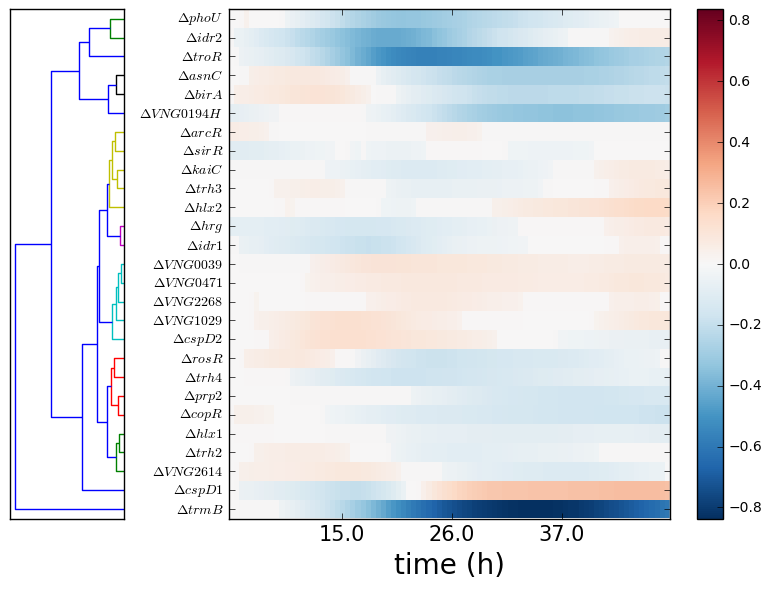

In [130]:
oddeltas = {}
ura3 = m.parameterSamples('alpha_0').values + m.parameterSamples('(alpha,beta)_(0,0)').values

for i,s in enumerate(labels[1:]):
        
    samples = m.parameterSamples('alpha_%d'%(i+1)).values + m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    oddeltas[s] = samples-ura3
    
keys,med,prob = extractDelta(oddeltas)
pd.DataFrame(med,index=keys,columns=m.x[:,0]).to_csv(os.path.join(thisDir,'batchEffects-corrected-standard_med.csv'))
pd.DataFrame(prob,index=keys,columns=m.x[:,0]).to_csv(os.path.join(thisDir,'batchEffects-corrected-standard_prob.csv'))
    
plt.figure(figsize=(8,6))
plot_delta(m.x[:,0],oddeltas,
            cluster=True,probability=True,plot_cluster=True,
            cluster_kwargs={"method":'complete'},dendrogram_kwargs={'color_threshold':1},
            ytick_filter=lambda x: '$\Delta '+x+'$')

plt.tight_layout()
plt.savefig(os.path.join('figures','batchEffects-corrected','standard-heatmap.pdf'),bbox_inches='tight',dpi=300)

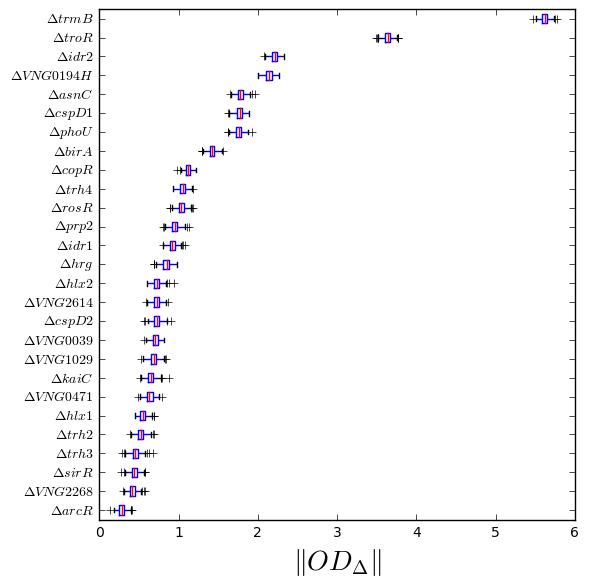

In [131]:
ura3 = m.parameterSamples('alpha_0').values + m.parameterSamples('(alpha,beta)_(0,0)').values

oddeltas = {}

plt.figure(figsize=(6,6))
for i,s in enumerate(labels[1:]):
        
    samples = m.parameterSamples('alpha_%d'%(i+1)).values + m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    oddeltas[s] = np.power(np.power(samples-ura3,2).sum(1),.5)

keys = oddeltas.keys()
oddeltaMeans = np.array([oddeltas[k].mean() for k in keys])
index = np.argsort(oddeltaMeans)
oddeltasSorted = np.array([oddeltas[k] for k in [oddeltas.keys()[i] for i in index]])
labelsSort = ["$\Delta "+s+"$" for s in keys]
labelsSort = [labelsSort[i] for i in index]
plt.boxplot(oddeltasSorted.T,vert=False,labels=labelsSort);
# plt.xscale('log')
plt.xlabel("$\|OD_\Delta\|$",fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join('figures','batchEffects-corrected','standard-oddeltaNorm.pdf'),bbox_inches='tight',dpi=300)

In [136]:
pd.DataFrame(oddeltas).T.to_csv(os.path.join(thisDir,'batchEffects-corrected-standard_oddeltaNorm.csv'))
oddeltas = pd.DataFrame(oddeltas).T

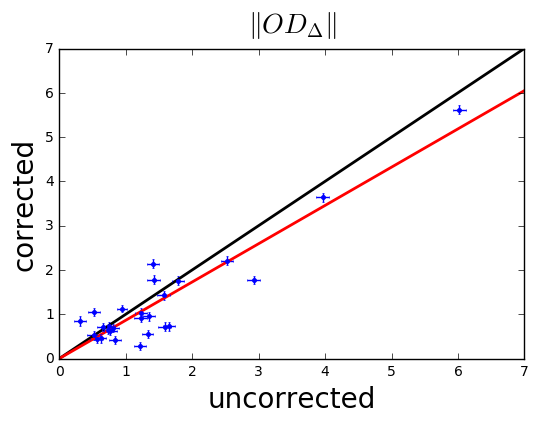

In [159]:
oddeltasUnnorm = pd.read_csv(os.path.join(thisDir,'standard_oddeltaNorm.csv'),index_col=0)

beta, resid, rank, s = np.linalg.lstsq(oddeltasUnnorm.median(1)[:,None],oddeltas.median(1))
plt.plot([0,7],[0,7],'k',lw=2)
plt.plot([0,7],[0,7*beta],'r',lw=2)

plt.errorbar(oddeltasUnnorm.median(1),oddeltas.median(1),xerr=oddeltasUnnorm.std(1)*2,yerr=oddeltas.std(1)*2,capsize=1,fmt='.')

plt.title('$\|OD_\Delta\|$',fontsize=20,y=1.03)
plt.xlabel("uncorrected",fontsize=20)
plt.ylabel("corrected",fontsize=20)

## Paraquat 

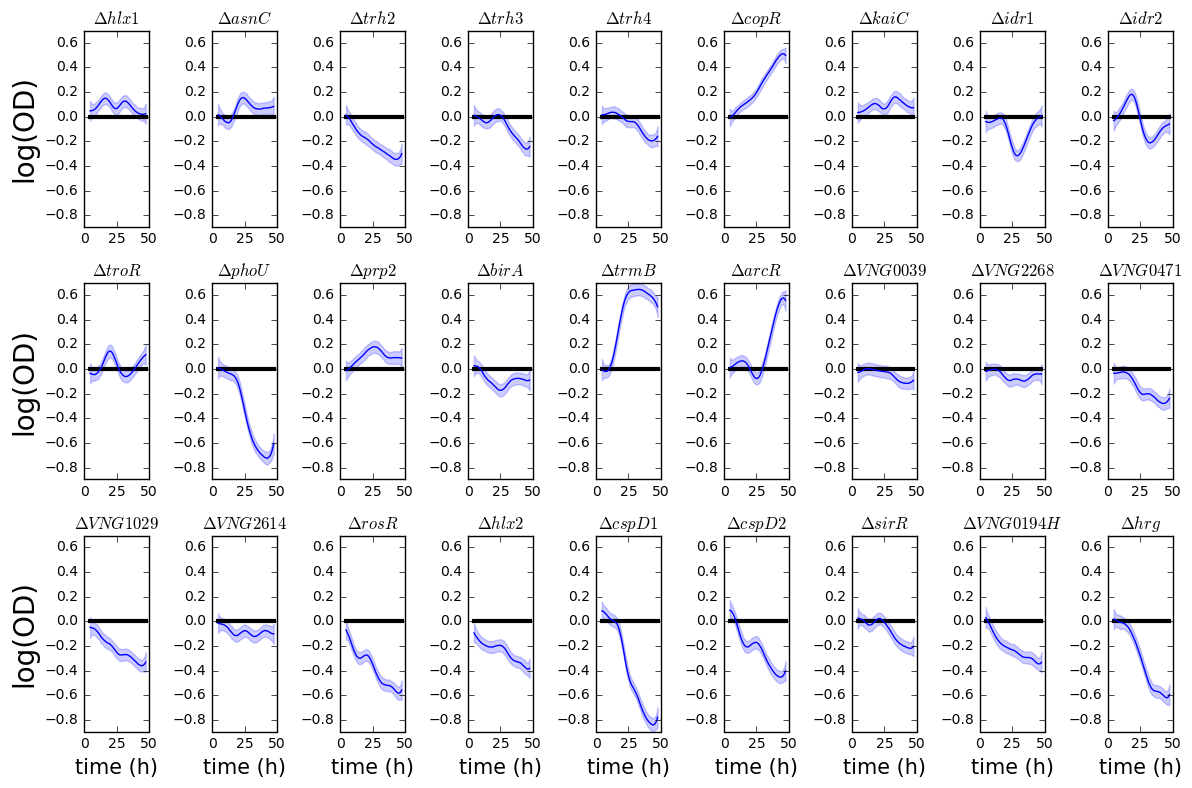

In [160]:
plt.figure(figsize=(12,8))
gpfanova.plot.plotInteraction(m,0,1,1,function=True,origin=True,relative=True,controlFixed=True,subplots=(3,9),color='b');

for i in range(27):
    plt.subplot(3,9,i+1); plt.title("$\Delta "+labels[i+1]+"$");
    plt.xticks([0,25,50])
    
    if (i)%9==0:
        plt.ylabel("log(OD)",fontsize=20)
    if i+1>9*2:
        plt.xlabel("time (h)",fontsize=15)


plt.tight_layout()
plt.savefig(os.path.join('figures','batchEffects-corrected','paraquat-oddelta.pdf'),bbox_inches='tight',dpi=300)

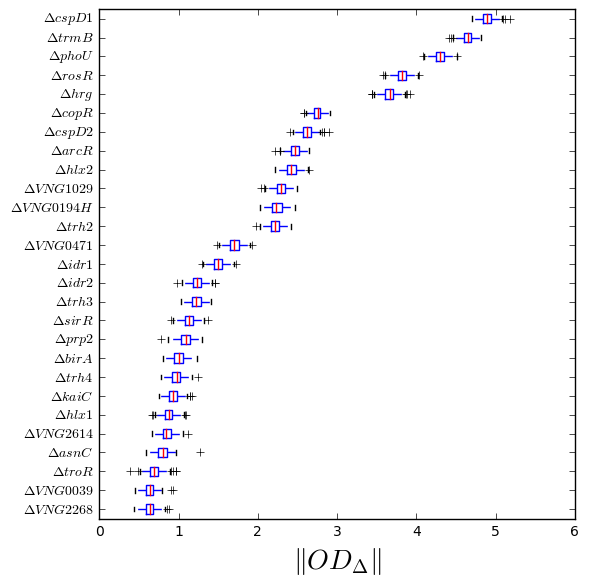

In [198]:
ura3 = m.parameterSamples('(alpha,beta)_(0,1)').values - m.parameterSamples('(alpha,beta)_(0,0)').values

oddeltas = {}

plt.figure(figsize=(6,6))
for i,s in enumerate(labels[1:]):
        
    samples = m.parameterSamples('(alpha,beta)_(%d,1)'%(i+1)).values - m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    oddeltas[s] = np.power(np.power(samples-ura3,2).sum(1),.5)

keys = oddeltas.keys()
oddeltaMeans = np.array([oddeltas[k].mean() for k in keys])
index = np.argsort(oddeltaMeans)
oddeltasSorted = np.array([oddeltas[k] for k in [oddeltas.keys()[i] for i in index]])
labelsSort = ["$\Delta "+s+"$" for s in keys]
labelsSort = [labelsSort[i] for i in index]
plt.boxplot(oddeltasSorted.T,vert=False,labels=labelsSort);
# plt.xscale('log')
plt.xlabel("$\|OD_\Delta\|$",fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join('figures','batchEffects-corrected','paraquat-oddeltaNorm.pdf'),bbox_inches='tight',dpi=300)

In [199]:
pd.DataFrame(oddeltas).T.to_csv(os.path.join(thisDir,'batchEffects-corrected-paraquat_oddeltaNorm.csv'))
oddeltas = pd.DataFrame(oddeltas).T

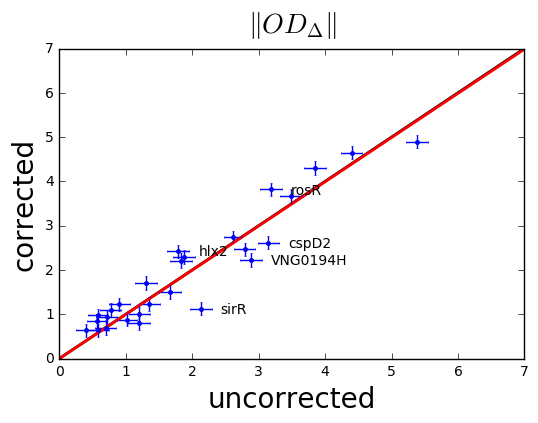

In [202]:
oddeltasUnnorm = pd.read_csv(os.path.join(thisDir,'paraquat_oddeltaNorm.csv'),index_col=0)

beta, resid, rank, s = np.linalg.lstsq(oddeltasUnnorm.median(1)[:,None],oddeltas.median(1))
plt.plot([0,7],[0,7],'k',lw=2)
plt.plot([0,7],[0,7*beta],'r',lw=2)

plt.errorbar(oddeltasUnnorm.median(1),oddeltas.median(1),xerr=oddeltasUnnorm.std(1)*2,yerr=oddeltas.std(1)*2,capsize=1,fmt='.')

for x,y,s in zip(oddeltasUnnorm.median(1),oddeltas.median(1),oddeltas.index):
    if abs(x-y)>.5:
        plt.text(x+.3,y-.1,s)

plt.title('$\|OD_\Delta\|$',fontsize=20,y=1.03)
plt.xlabel("uncorrected",fontsize=20)
plt.ylabel("corrected",fontsize=20)

In [164]:
oddeltas = {}
ura3 = m.parameterSamples('(alpha,beta)_(0,1)').values - m.parameterSamples('(alpha,beta)_(0,0)').values

for i,s in enumerate(labels[1:]):
        
    samples = m.parameterSamples('(alpha,beta)_(%d,1)'%(i+1)).values - m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    oddeltas[s] = samples-ura3
    
keys,med,prob = extractDelta(oddeltas)
pd.DataFrame(med,index=keys,columns=m.x[:,0]).to_csv(os.path.join(thisDir,'batchEffects-corrected-paraquat_med.csv'))
pd.DataFrame(prob,index=keys,columns=m.x[:,0]).to_csv(os.path.join(thisDir,'batchEffects-corrected-paraquat_prob.csv'))

/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


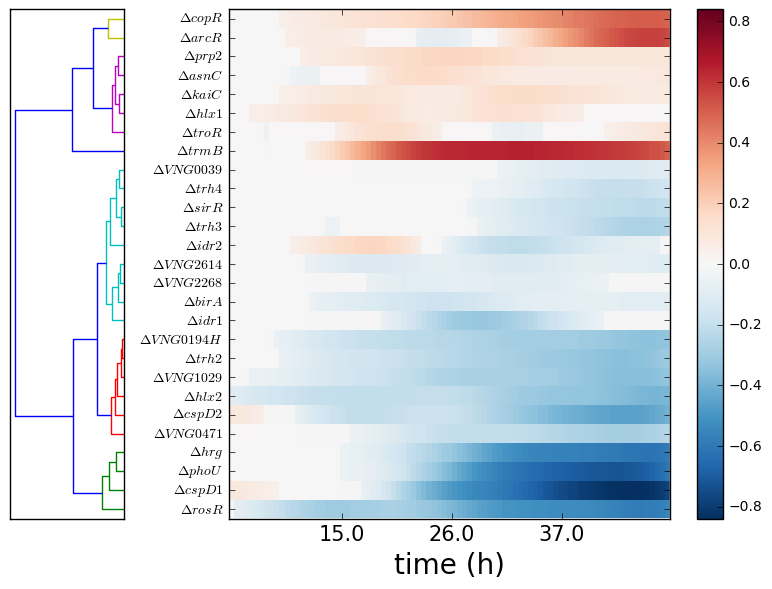

In [165]:
plt.figure(figsize=(8,6))
# plot_delta(m.x[:,0],oddeltas,cluster=True,probability=True,plot_cluster=True,ytick_filter=lambda x: '$\Delta '+x+'$')
plot_delta(m.x[:,0],oddeltas,
            cluster=True,probability=True,plot_cluster=True,
            cluster_kwargs={"method":'complete'},dendrogram_kwargs={'color_threshold':2},
            ytick_filter=lambda x: '$\Delta '+x+'$')
plt.tight_layout()
plt.savefig(os.path.join('figures','batchEffects-corrected','paraquat-heatmap.pdf'),bbox_inches='tight',dpi=300)

## Osmotic 

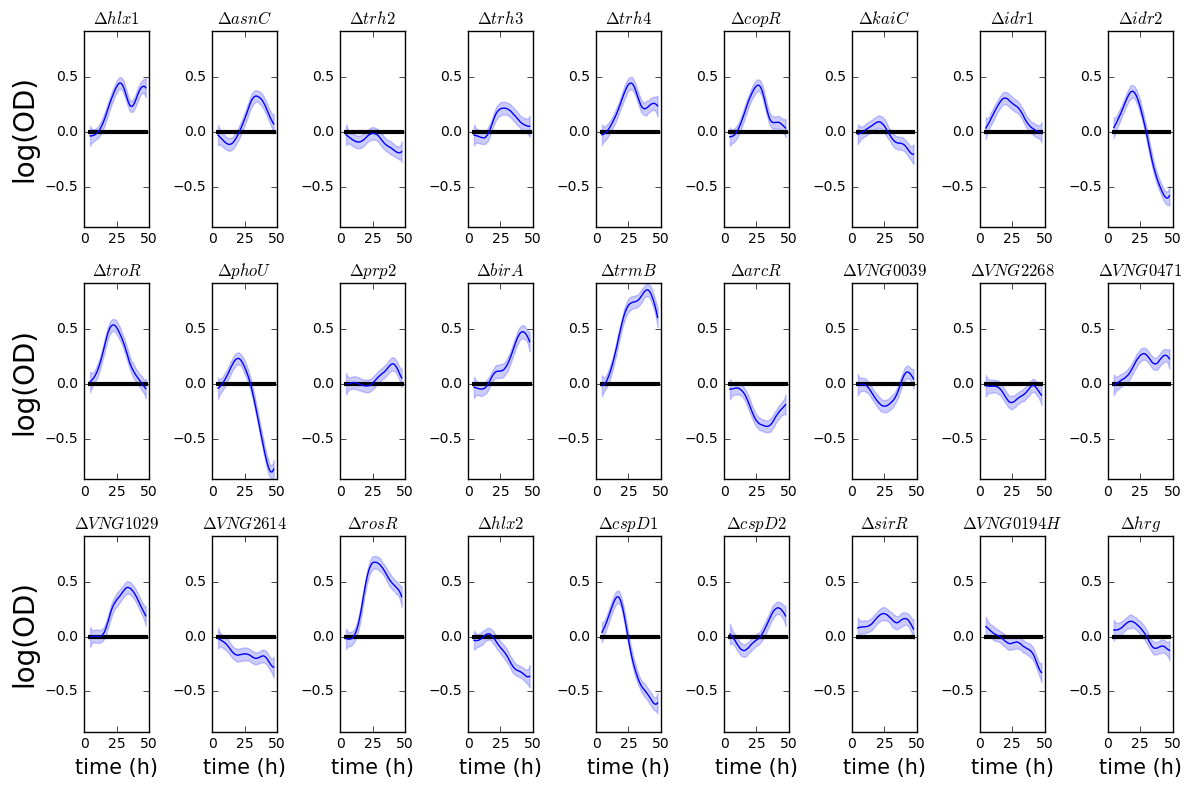

In [166]:
plt.figure(figsize=(12,8))
gpfanova.plot.plotInteraction(m,0,1,2,function=True,origin=True,relative=True,controlFixed=True,subplots=(3,9),color='b');

for i in range(27):
    plt.subplot(3,9,i+1); plt.title("$\Delta "+labels[i+1]+"$");
    plt.xticks([0,25,50])
    
    if (i)%9==0:
        plt.ylabel("log(OD)",fontsize=20)
    if i+1>9*2:
        plt.xlabel("time (h)",fontsize=15)


plt.tight_layout()
plt.savefig(os.path.join('figures','batchEffects-corrected','osmotic-oddelta.pdf'),bbox_inches='tight',dpi=300)

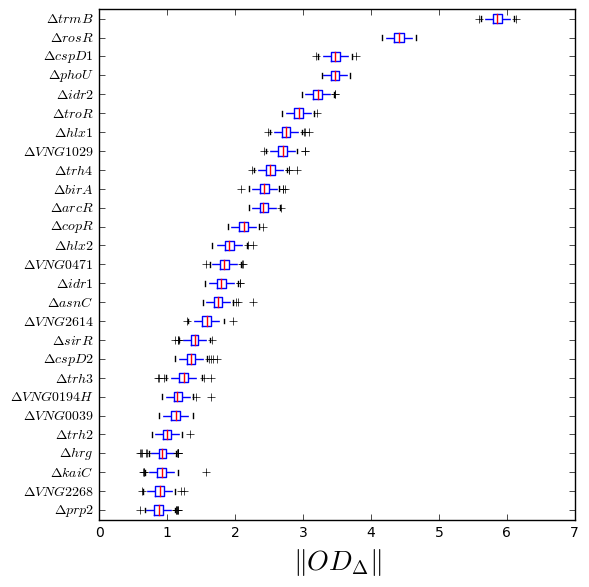

In [186]:
ura3 = m.parameterSamples('(alpha,beta)_(0,2)').values - m.parameterSamples('(alpha,beta)_(0,0)').values

oddeltas = {}

plt.figure(figsize=(6,6))
for i,s in enumerate(labels[1:]):
        
    samples = m.parameterSamples('(alpha,beta)_(%d,2)'%(i+1)).values - m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    oddeltas[s] = np.power(np.power(samples-ura3,2).sum(1),.5)

keys = oddeltas.keys()
oddeltaMeans = np.array([oddeltas[k].mean() for k in keys])
index = np.argsort(oddeltaMeans)
oddeltasSorted = np.array([oddeltas[k] for k in [oddeltas.keys()[i] for i in index]])
labelsSort = ["$\Delta "+s+"$" for s in keys]
labelsSort = [labelsSort[i] for i in index]
plt.boxplot(oddeltasSorted.T,vert=False,labels=labelsSort);
# plt.xscale('log')
plt.xlabel("$\|OD_\Delta\|$",fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join('figures','batchEffects-corrected','osmotic-oddeltaNorm.pdf'),bbox_inches='tight',dpi=300)

In [187]:
pd.DataFrame(oddeltas).T.to_csv(os.path.join(thisDir,'batchEffects-corrected-osmotic_oddeltaNorm.csv'))
oddeltas = pd.DataFrame(oddeltas).T

In [188]:
oddeltas.shape,oddeltasUnnorm.shape

((27, 334), (27, 1627))

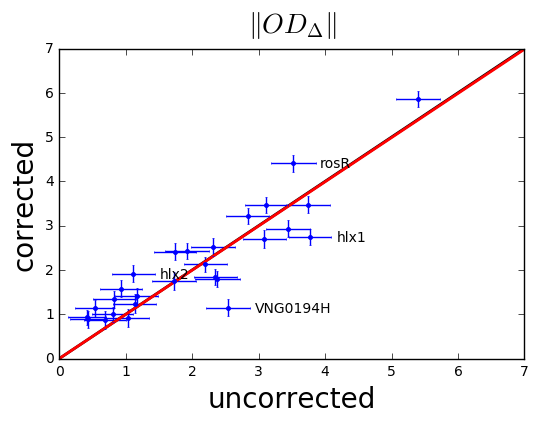

In [197]:
oddeltasUnnorm = pd.read_csv(os.path.join(thisDir,'osmotic_oddeltaNorm.csv'),index_col=0)

beta, resid, rank, s = np.linalg.lstsq(oddeltasUnnorm.median(1)[:,None],oddeltas.median(1))
plt.plot([0,7],[0,7],'k',lw=2)
plt.plot([0,7],[0,7*beta],'r',lw=2)

plt.errorbar(oddeltasUnnorm.median(1),oddeltas.median(1),xerr=oddeltasUnnorm.std(1)*2,yerr=oddeltas.std(1)*2,capsize=1,fmt='.')

for x,y,s in zip(oddeltasUnnorm.median(1),oddeltas.median(1),oddeltas.index):
    if abs(x-y)>.75:
        plt.text(x+.4,y-.1,s)

plt.title('$\|OD_\Delta\|$',fontsize=20,y=1.03)
plt.xlabel("uncorrected",fontsize=20)
plt.ylabel("corrected",fontsize=20)

/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


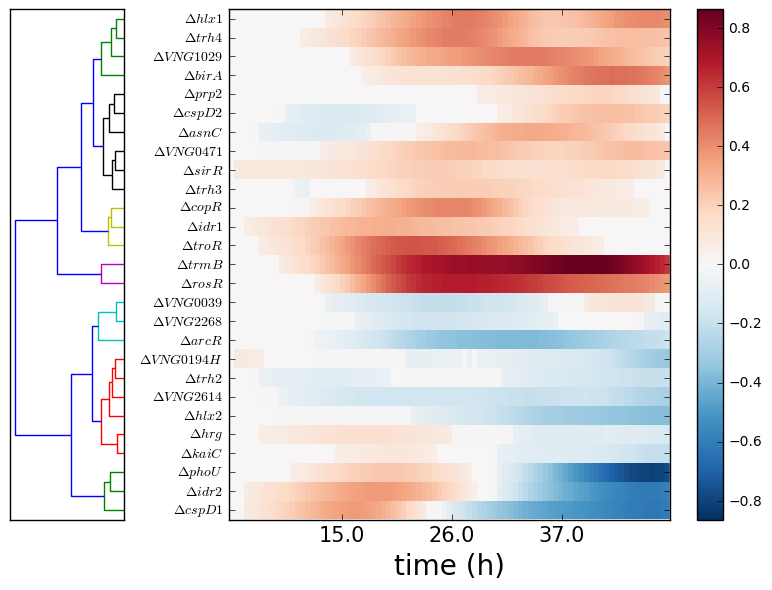

In [184]:
oddeltas = {}
ura3 = m.parameterSamples('(alpha,beta)_(0,2)').values - m.parameterSamples('(alpha,beta)_(0,0)').values

for i,s in enumerate(labels[1:]):
        
    samples = m.parameterSamples('(alpha,beta)_(%d,2)'%(i+1)).values - m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    oddeltas[s] = samples-ura3
    
keys,med,prob = extractDelta(oddeltas)
pd.DataFrame(med,index=keys,columns=m.x[:,0]).to_csv(os.path.join(thisDir,'batchEffects-corrected-osmotic_med.csv'))
pd.DataFrame(prob,index=keys,columns=m.x[:,0]).to_csv(os.path.join(thisDir,'batchEffects-corrected-osmotic_prob.csv'))
    
plt.figure(figsize=(8,6))
# plot_delta(m.x[:,0],oddeltas,cluster=True,probability=True,plot_cluster=True,ytick_filter=lambda x: '$\Delta '+x+'$')
plot_delta(m.x[:,0],oddeltas,
            cluster=True,probability=True,plot_cluster=True,
            cluster_kwargs={"method":'complete'},dendrogram_kwargs={'color_threshold':2},
            ytick_filter=lambda x: '$\Delta '+x+'$')
plt.tight_layout()
plt.savefig(os.path.join('figures','batchEffects-corrected','osmotic-heatmap.pdf'),bbox_inches='tight',dpi=300)

## Peroxide 

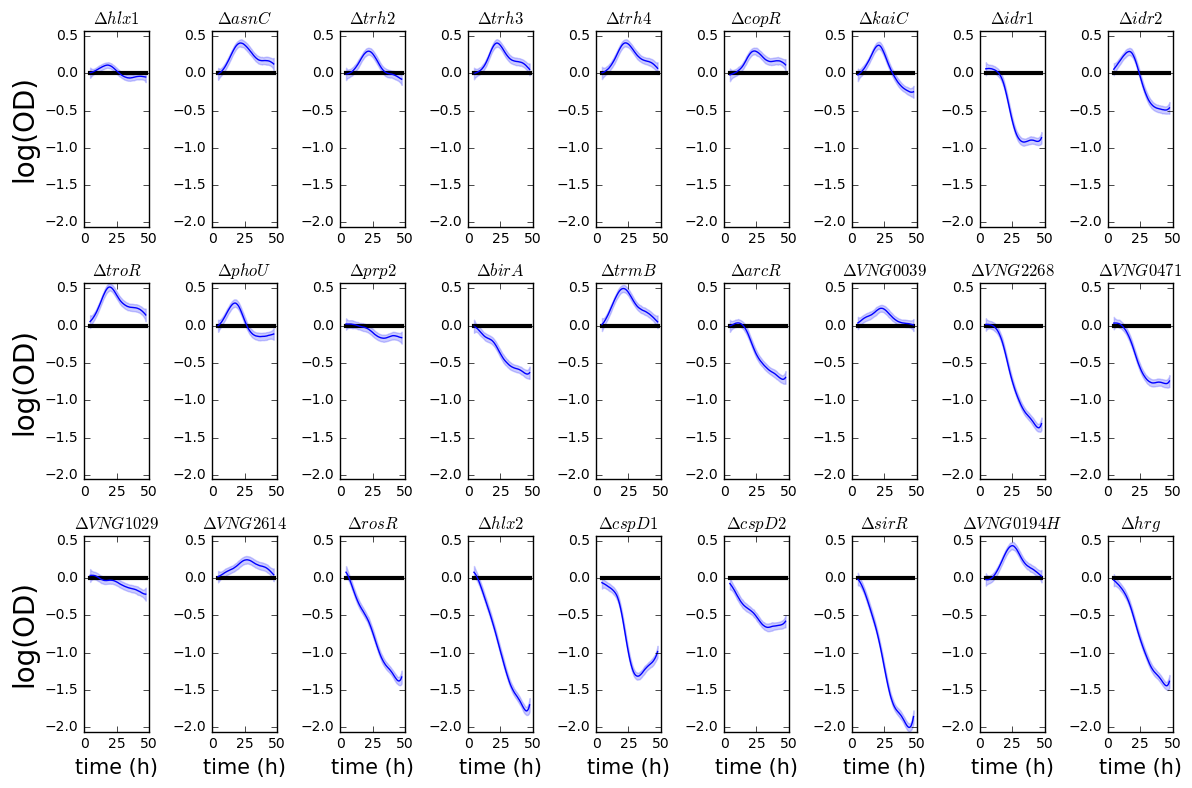

In [203]:
plt.figure(figsize=(12,8))
gpfanova.plot.plotInteraction(m,0,1,3,function=True,origin=True,relative=True,controlFixed=True,subplots=(3,9),color='b');

for i in range(27):
    plt.subplot(3,9,i+1); plt.title("$\Delta "+labels[i+1]+"$");
    plt.xticks([0,25,50])
    
    if (i)%9==0:
        plt.ylabel("log(OD)",fontsize=20)
    if i+1>9*2:
        plt.xlabel("time (h)",fontsize=15)


plt.tight_layout()
plt.savefig(os.path.join('figures','batchEffects-corrected','peroxide-oddelta.pdf'),bbox_inches='tight',dpi=300)

/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


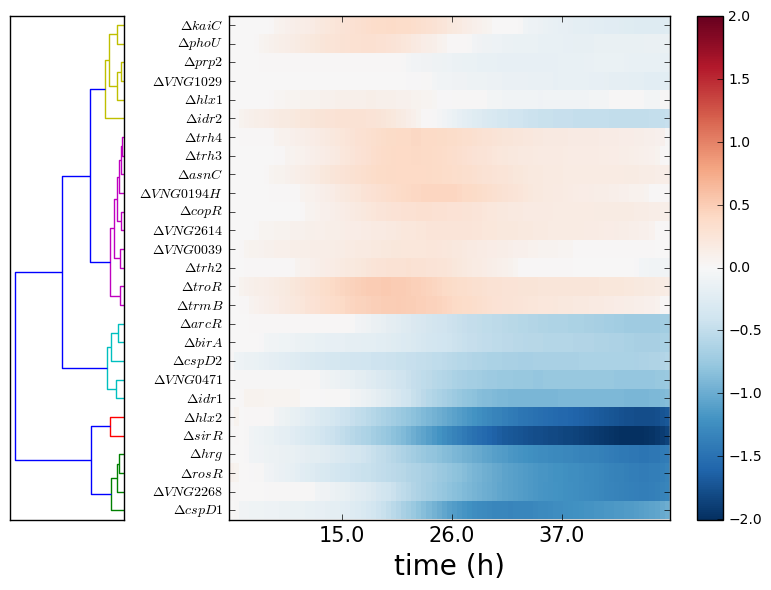

In [204]:
oddeltas = {}
ura3 = m.parameterSamples('(alpha,beta)_(0,3)').values - m.parameterSamples('(alpha,beta)_(0,0)').values

for i,s in enumerate(labels[1:]):
        
    samples = m.parameterSamples('(alpha,beta)_(%d,3)'%(i+1)).values - m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    oddeltas[s] = samples-ura3
    
keys,med,prob = extractDelta(oddeltas)
# pd.DataFrame(med,index=keys,columns=m.x[:,0]).to_csv(os.path.join(thisDir,'osmotic_med.csv'))
# pd.DataFrame(prob,index=keys,columns=m.x[:,0]).to_csv(os.path.join(thisDir,'osmotic_prob.csv'))
    
plt.figure(figsize=(8,6))
# plot_delta(m.x[:,0],oddeltas,cluster=True,probability=True,plot_cluster=True,ytick_filter=lambda x: '$\Delta '+x+'$')
plot_delta(m.x[:,0],oddeltas,
            cluster=True,probability=True,plot_cluster=True,
            cluster_kwargs={"method":'complete'},dendrogram_kwargs={'color_threshold':4},
            ytick_filter=lambda x: '$\Delta '+x+'$')
plt.tight_layout()
plt.savefig(os.path.join('figures','batchEffects-corrected','peroxide-heatmap.pdf'),bbox_inches='tight',dpi=300)

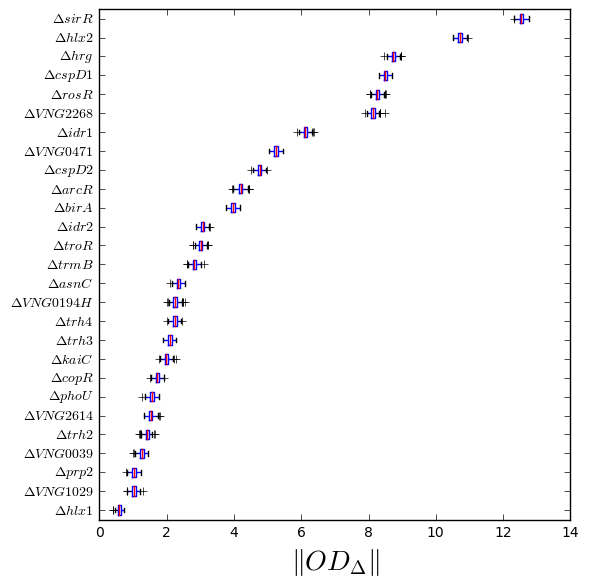

In [205]:
ura3 = m.parameterSamples('(alpha,beta)_(0,3)').values - m.parameterSamples('(alpha,beta)_(0,0)').values

oddeltas = {}

plt.figure(figsize=(6,6))
for i,s in enumerate(labels[1:]):
        
    samples = m.parameterSamples('(alpha,beta)_(%d,3)'%(i+1)).values - m.parameterSamples('(alpha,beta)_(%d,0)'%(i+1)).values
    oddeltas[s] = np.power(np.power(samples-ura3,2).sum(1),.5)

keys = oddeltas.keys()
oddeltaMeans = np.array([oddeltas[k].mean() for k in keys])
index = np.argsort(oddeltaMeans)
oddeltasSorted = np.array([oddeltas[k] for k in [oddeltas.keys()[i] for i in index]])
labelsSort = ["$\Delta "+s+"$" for s in keys]
labelsSort = [labelsSort[i] for i in index]
plt.boxplot(oddeltasSorted.T,vert=False,labels=labelsSort);
# plt.xscale('log')
plt.xlabel("$\|OD_\Delta\|$",fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join('figures','batchEffects-corrected','peroxide-oddeltaNorm.pdf'),bbox_inches='tight',dpi=300)